# Google Earth Engine Data Preparation for FuseTS

This notebook extracts Sentinel-1 and Sentinel-2 data from Google Earth Engine and prepares it for FuseTS MOGPR processing.

## Temporal Compositing Strategy
- **Total periods**: 31 periods from Nov 2024 - Oct 2025
- **Period length**: 12 days each
- **Start date**: November 1, 2024
- **End date**: October 31, 2025
- **Period 1**: Nov 1-12, 2024
- **Period 2**: Nov 13-24, 2024  
- **Period 3**: Nov 25 - Dec 6, 2024
- **... and so on**

## Indonesian Agricultural Calendar Coverage
This date range perfectly captures:
- **First planting season**: Nov 2024 - Mar 2025 (crosses year boundary)
- **Second planting season**: Apr - Jun 2025
- **Third planting season**: Jul - Sep 2025 (optional)
- **Full cycle**: Complete agricultural year

## Output Format
Data will be exported in FuseTS-compatible xarray format with proper band naming:
- S1: `VV`, `VH` bands
- S2: `S2ndvi` band
- Dimensions: `(time, y, x)` with `t` coordinate name

## 1. Setup and Authentication

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install rasterio earthengine-api geemap pandas numpy xarray matplotlib geopandas shapely

In [1]:
import ee
import geemap

In [2]:
ee.Authenticate()

True

In [3]:
#ee.Authenticate()
ee.Initialize(project='ee-geodeticengineeringundip')


In [4]:
import ee
import geemap
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
import warnings
warnings.filterwarnings('ignore')

# Additional imports for mask processing
import rasterio
from rasterio.features import shapes
import geopandas as gpd
from shapely.geometry import shape, mapping
from shapely.ops import unary_union

# Initialize Earth Engine with authentication
print("🔐 Authenticating with Google Earth Engine...")

try:
    # First time setup: authenticate
    ee.Authenticate()
    print("✅ Authentication successful!")
except Exception as e:
    print(f"Authentication note: {e}")
    print("If already authenticated, continuing...")

# Initialize with project
try:
    ee.Initialize(project='ee-geodeticengineeringundip')
    print("✅ Earth Engine initialized successfully!")
    print(f"   Project: ee-geodeticengineeringundip")
except Exception as e:
    print(f"❌ Error initializing Earth Engine: {e}")
    print("Please ensure:")
    print("  1. You have run ee.Authenticate() successfully")
    print("  2. You have access to project 'ee-geodeticengineeringundip'")
    raise

print(f"\n📦 Package versions:")
print(f"   Earth Engine API: {ee.__version__}")
print(f"   geemap: {geemap.__version__}")
print(f"   rasterio: {rasterio.__version__}")


🔐 Authenticating with Google Earth Engine...
✅ Authentication successful!
✅ Earth Engine initialized successfully!
   Project: ee-geodeticengineeringundip

📦 Package versions:
   Earth Engine API: 1.6.15
   geemap: 0.36.6
   rasterio: 1.4.3


## 2. Define Study Area and Parameters

📍 STUDY AREA CONFIGURATION

🎯 Using Paddy Shapefile: data/klambu-glapan.shp

✅ Shapefile loaded successfully!
   Number of features: 1043
   CRS: EPSG:4326
   Columns: ['n_di', 'nama', 'id_di', 'norec', 'k_aset', 'n_aset', 'dimensi', 'nomenklatu', 'layer', 'path', 'geometry']

   Original Bounds (in EPSG:4326):
     West:  110.517654°
     South: -7.108495°
     East:  111.033707°
     North: -6.717609°

   Converting to UTM Zone 49S for accurate buffering...
   Total paddy area: 559.46 km²

   UTM Bounds (Zone 49S, EPSG:32749):
     MinX: 446717.60 m
     MinY: 9214245.81 m
     MaxX: 503724.45 m
     MaxY: 9257454.77 m
     Width:  57006.85 m (57.01 km)
     Height: 43208.96 m (43.21 km)

   Applying 500m buffer (in UTM)...
   Buffered area: 879.84 km²

   Converting back to WGS84 for Earth Engine...
   WGS84 Bounds (for Earth Engine):
     West:  110.513130°
     South: -7.113018°
     East:  111.038229°
     North: -6.713087°
   ✅ Coordinates verified - location is in Central Java


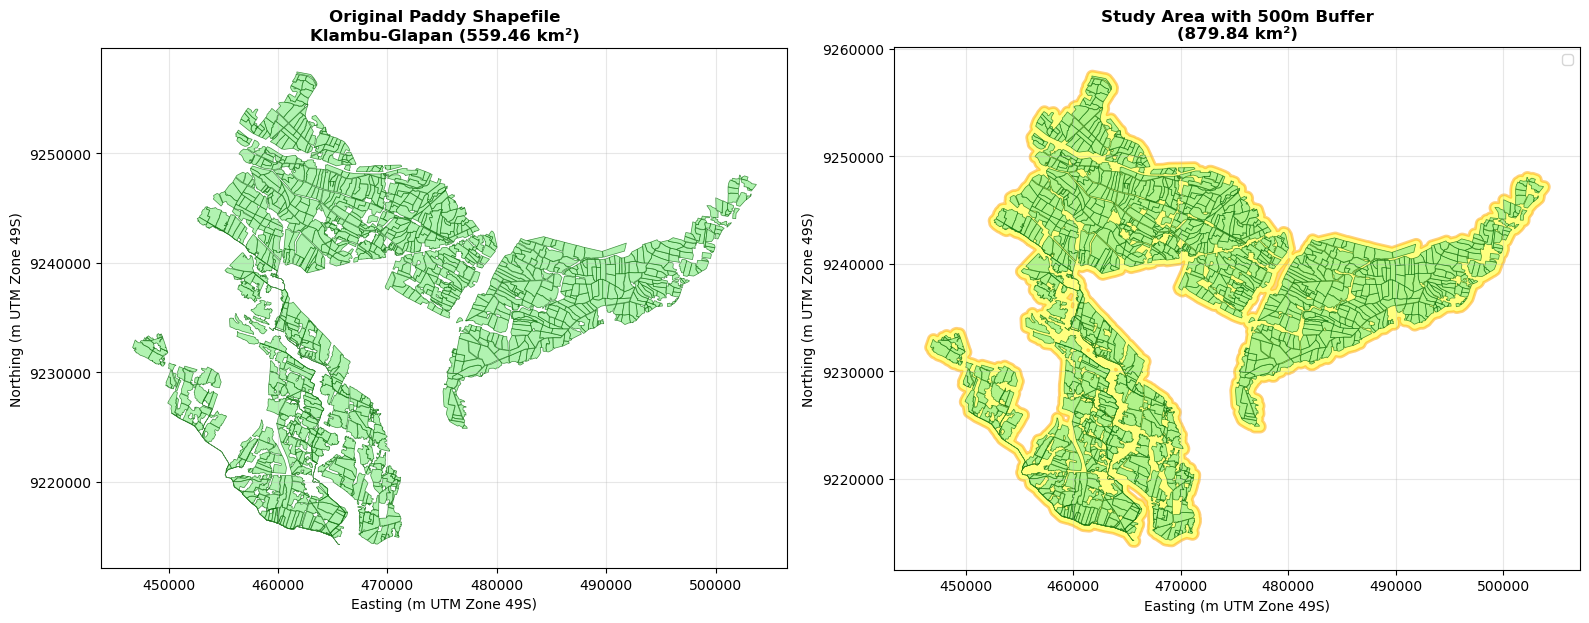


   📊 Visualization saved: study_area_shapefile.png

📋 FINAL PROCESSING CONFIGURATION
   Study Area: KLAMBU_GLAPAN_SHAPEFILE
   Source: data/klambu-glapan.shp
   Bounds (WGS84): 
     West:  110.513130°
     South: -7.113018°
     East:  111.038229°
     North: -6.713087°
   Area size: 884.30 km²
   Buffer: 500m

   Temporal coverage: 2023-11-01 to 2025-11-07
   Time span: ~2 years
   Temporal resolution: 12-day composites (dekadal)
   Spatial resolution: 10m
   Coordinate system: EPSG:4326
   Max cloud cover: 80%
   Output directory: gee_fusets_data/

💾 Estimated data size:
   Number of periods: 62
   Pixels per period: 8,843,014
   Per period: ~0.106 GB
   Total (62 periods): ~6.58 GB

   ✅ Small dataset - Google Drive export is fine

📍 STUDY AREA SUMMARY:
   Location: Klambu-Glapan paddy fields, Demak, Central Java
   Features: 1043 paddy field polygons
   Original area: 559.46 km²
   With buffer: 879.84 km²
   Purpose: Precision agriculture / rice phenology monitoring
   Advantage:

In [5]:
# ============================================================================
# STUDY AREA FROM SHAPEFILE
# ============================================================================

print("="*70)
print("📍 STUDY AREA CONFIGURATION")
print("="*70)

# Load the paddy shapefile
shapefile_path = 'data/klambu-glapan.shp'

print(f"\n🎯 Using Paddy Shapefile: {shapefile_path}")

try:
    # Read the shapefile
    paddy_gdf = gpd.read_file(shapefile_path)
    
    print(f"\n✅ Shapefile loaded successfully!")
    print(f"   Number of features: {len(paddy_gdf)}")
    print(f"   CRS: {paddy_gdf.crs}")
    print(f"   Columns: {paddy_gdf.columns.tolist()}")
    
    # Get original bounds
    orig_west, orig_south, orig_east, orig_north = paddy_gdf.total_bounds
    print(f"\n   Original Bounds (in {paddy_gdf.crs}):")
    print(f"     West:  {orig_west:.6f}°")
    print(f"     South: {orig_south:.6f}°")
    print(f"     East:  {orig_east:.6f}°")
    print(f"     North: {orig_north:.6f}°")
    
    # Calculate area in original CRS (won't be accurate in degrees)
    # We need to convert to a projected CRS (UTM) first
    
    # Convert to UTM Zone 49S (EPSG:32749) - appropriate for Central Java, Indonesia
    print(f"\n   Converting to UTM Zone 49S for accurate buffering...")
    paddy_utm = paddy_gdf.to_crs("EPSG:32749")
    
    # Calculate accurate area in UTM
    total_area_m2 = paddy_utm.area.sum()
    total_area_km2 = total_area_m2 / 1e6
    print(f"   Total paddy area: {total_area_km2:.2f} km²")
    
    # Get bounds in UTM
    minx_utm, miny_utm, maxx_utm, maxy_utm = paddy_utm.total_bounds
    print(f"\n   UTM Bounds (Zone 49S, EPSG:32749):")
    print(f"     MinX: {minx_utm:.2f} m")
    print(f"     MinY: {miny_utm:.2f} m")
    print(f"     MaxX: {maxx_utm:.2f} m")
    print(f"     MaxY: {maxy_utm:.2f} m")
    print(f"     Width:  {(maxx_utm - minx_utm):.2f} m ({(maxx_utm - minx_utm)/1000:.2f} km)")
    print(f"     Height: {(maxy_utm - miny_utm):.2f} m ({(maxy_utm - miny_utm)/1000:.2f} km)")
    
    # Add buffer in UTM (meters)
    BUFFER_DISTANCE_M = 500  # 500 meters buffer
    print(f"\n   Applying {BUFFER_DISTANCE_M}m buffer (in UTM)...")
    
    # Create buffered geometry in UTM
    paddy_buffered_utm = paddy_utm.copy()
    paddy_buffered_utm['geometry'] = paddy_utm.buffer(BUFFER_DISTANCE_M)
    
    # Merge all buffered polygons into one
    merged_geometry_utm = unary_union(paddy_buffered_utm.geometry)
    buffered_area_km2 = merged_geometry_utm.area / 1e6
    
    print(f"   Buffered area: {buffered_area_km2:.2f} km²")
    
    # Convert back to WGS84 for Earth Engine
    print(f"\n   Converting back to WGS84 for Earth Engine...")
    
    # Create GeoDataFrame with merged buffered geometry (in UTM)
    buffered_gdf_utm = gpd.GeoDataFrame(
        geometry=[merged_geometry_utm],
        crs="EPSG:32749"
    )
    
    # Convert to WGS84
    buffered_gdf_wgs84 = buffered_gdf_utm.to_crs("EPSG:4326")
    
    # Get WGS84 bounds
    west, south, east, north = buffered_gdf_wgs84.total_bounds
    
    print(f"   WGS84 Bounds (for Earth Engine):")
    print(f"     West:  {west:.6f}°")
    print(f"     South: {south:.6f}°")
    print(f"     East:  {east:.6f}°")
    print(f"     North: {north:.6f}°")
    
    # Verify coordinates are reasonable (Java, Indonesia should be around 110°E, 6-7°S)
    if not (109 < west < 112 and 109 < east < 112 and -8 < south < -6 and -8 < north < -6):
        print(f"\n   ⚠️  WARNING: Coordinates seem unusual for Java, Indonesia!")
        print(f"   Expected: ~110°E, ~6-7°S")
    else:
        print(f"   ✅ Coordinates verified - location is in Central Java")
    
    # Convert to GeoJSON for Earth Engine
    geojson_geom = mapping(buffered_gdf_wgs84.geometry.iloc[0])
    
    # Create Earth Engine Geometry
    study_area = ee.Geometry(geojson_geom)
    
    gee_area_km2 = study_area.area().getInfo() / 1e6
    
    print(f"\n✅ Study area created from shapefile!")
    print(f"   Type: Paddy field boundaries (Klambu-Glapan)")
    print(f"   Location: Demak, Central Java, Indonesia")
    print(f"   Buffer: {BUFFER_DISTANCE_M}m around paddy fields")
    print(f"   Area (GEE): {gee_area_km2:.2f} km²")
    
    # Visualize the shapefile
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Plot 1: Original shapefile (in UTM for proper scale)
    ax1 = axes[0]
    paddy_utm.plot(ax=ax1, facecolor='lightgreen', edgecolor='darkgreen', 
                   linewidth=0.5, alpha=0.7)
    ax1.set_title(f'Original Paddy Shapefile\nKlambu-Glapan ({total_area_km2:.2f} km²)', 
                  fontsize=12, fontweight='bold')
    ax1.set_xlabel('Easting (m UTM Zone 49S)')
    ax1.set_ylabel('Northing (m UTM Zone 49S)')
    ax1.grid(True, alpha=0.3)
    ax1.ticklabel_format(style='plain')
    
    # Plot 2: With buffer (in UTM for proper scale)
    ax2 = axes[1]
    buffered_gdf_utm.plot(ax=ax2, facecolor='yellow', edgecolor='orange', 
                          linewidth=2, alpha=0.5, label=f'{BUFFER_DISTANCE_M}m buffer')
    paddy_utm.plot(ax=ax2, facecolor='lightgreen', edgecolor='darkgreen', 
                   linewidth=0.5, alpha=0.7, label='Paddy areas')
    ax2.set_title(f'Study Area with {BUFFER_DISTANCE_M}m Buffer\n({buffered_area_km2:.2f} km²)', 
                  fontsize=12, fontweight='bold')
    ax2.set_xlabel('Easting (m UTM Zone 49S)')
    ax2.set_ylabel('Northing (m UTM Zone 49S)')
    ax2.legend(loc='best', fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.ticklabel_format(style='plain')
    
    plt.tight_layout()
    plt.savefig('study_area_shapefile.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n   📊 Visualization saved: study_area_shapefile.png")
    
    # Set study area type
    STUDY_AREA_TYPE = 'klambu_glapan_shapefile'
    
except FileNotFoundError:
    print(f"\n❌ ERROR: Shapefile not found!")
    print(f"   Expected path: {shapefile_path}")
    print(f"   Please ensure the shapefile exists in the data/ folder")
    raise
    
except Exception as e:
    print(f"\n❌ ERROR loading shapefile: {e}")
    import traceback
    traceback.print_exc()
    raise

# Processing parameters
START_DATE = '2023-11-01'  # November 1, 2023
END_DATE = '2025-11-07'    # November 7, 2025 (current date)
SCALE = 10  # meters per pixel (10m = native S2 resolution)
CRS = 'EPSG:4326'  # WGS84 coordinate system
MAX_CLOUD_COVER = 80  # Maximum cloud cover percentage for S2 (relaxed for tropics)

# Output directory
OUTPUT_DIR = 'gee_fusets_data'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Display final configuration
print(f"\n{'='*70}")
print("📋 FINAL PROCESSING CONFIGURATION")
print(f"{'='*70}")
print(f"   Study Area: {STUDY_AREA_TYPE.upper()}")
print(f"   Source: {shapefile_path}")
print(f"   Bounds (WGS84): ")
print(f"     West:  {west:.6f}°")
print(f"     South: {south:.6f}°")
print(f"     East:  {east:.6f}°")
print(f"     North: {north:.6f}°")
print(f"   Area size: {gee_area_km2:.2f} km²")
print(f"   Buffer: {BUFFER_DISTANCE_M}m")
print(f"\n   Temporal coverage: {START_DATE} to {END_DATE}")
print(f"   Time span: ~2 years")
print(f"   Temporal resolution: 12-day composites (dekadal)")
print(f"   Spatial resolution: {SCALE}m")
print(f"   Coordinate system: {CRS}")
print(f"   Max cloud cover: {MAX_CLOUD_COVER}%")
print(f"   Output directory: {OUTPUT_DIR}/")

# Estimate data size
area_km2 = gee_area_km2
pixels_per_period = (area_km2 * 1e6) / (SCALE * SCALE)  # Total pixels

# Calculate number of periods from Nov 2023 to Nov 2025
days = (datetime.strptime(END_DATE, '%Y-%m-%d') - datetime.strptime(START_DATE, '%Y-%m-%d')).days
num_periods = int(np.ceil(days / 12))

bands = 3  # VV, VH, S2ndvi
bytes_per_pixel = 4  # Float32
total_size_gb = (pixels_per_period * bands * bytes_per_pixel * num_periods) / 1e9

print(f"\n💾 Estimated data size:")
print(f"   Number of periods: {num_periods}")
print(f"   Pixels per period: {pixels_per_period:,.0f}")
print(f"   Per period: ~{total_size_gb/num_periods:.3f} GB")
print(f"   Total ({num_periods} periods): ~{total_size_gb:.2f} GB")

if total_size_gb > 250:
    print(f"\n   ⚠️  WARNING: Exceeds GEE Asset quota (250GB)")
    print(f"   → Consider reducing temporal coverage or using Google Drive")
elif total_size_gb > 100:
    print(f"\n   ⚡ Large dataset - GEE Assets recommended")
elif total_size_gb > 10:
    print(f"\n   ✅ Medium dataset - Both GEE Assets and Drive work well")
else:
    print(f"\n   ✅ Small dataset - Google Drive export is fine")

print(f"{'='*70}")

# Summary
print(f"\n📍 STUDY AREA SUMMARY:")
print(f"   Location: Klambu-Glapan paddy fields, Demak, Central Java")
print(f"   Features: {len(paddy_gdf)} paddy field polygons")
print(f"   Original area: {total_area_km2:.2f} km²")
print(f"   With buffer: {buffered_area_km2:.2f} km²")
print(f"   Purpose: Precision agriculture / rice phenology monitoring")
print(f"   Advantage: Only downloads data for actual paddy areas (not entire region)")

print(f"\n✅ Ready to proceed with data extraction!")

## 2b. Load Paddy Shapefile Mask (Klambu-Glapan)

In [ ]:
# ============================================================================
# LOAD PADDY SHAPEFILE AND CREATE STUDY AREA FROM IT
# ============================================================================

print("="*70)
print("📍 LOADING PADDY SHAPEFILE MASK")
print("="*70)

# Load the shapefile
shapefile_path = 'data/klambu-glapan.shp'

try:
    paddy_gdf = gpd.read_file(shapefile_path)
    
    print(f"\n✅ Shapefile loaded successfully!")
    print(f"   File: {shapefile_path}")
    print(f"   Number of features: {len(paddy_gdf)}")
    print(f"   CRS: {paddy_gdf.crs}")
    print(f"   Total area: {paddy_gdf.area.sum() / 1e6:.2f} km²")
    
    # Get bounds in original CRS
    minx, miny, maxx, maxy = paddy_gdf.total_bounds
    print(f"\n   Original CRS Bounds:")
    print(f"     West (MinX):  {minx:.2f}")
    print(f"     South (MinY): {miny:.2f}")
    print(f"     East (MaxX):  {maxx:.2f}")
    print(f"     North (MaxY): {maxy:.2f}")
    print(f"     Width:  {(maxx - minx):.2f} m ({(maxx - minx)/1000:.2f} km)")
    print(f"     Height: {(maxy - miny):.2f} m ({(maxy - miny)/1000:.2f} km)")
    
    # Add buffer around shapefile (500m buffer)
    buffer_m = 500
    print(f"\n   Applying {buffer_m}m buffer to paddy areas...")
    
    # Buffer in the original CRS (should be meters)
    paddy_buffered = paddy_gdf.copy()
    paddy_buffered['geometry'] = paddy_gdf.buffer(buffer_m)
    
    # Convert to WGS84 (EPSG:4326) for GEE
    paddy_wgs84 = paddy_buffered.to_crs("EPSG:4326")
    
    # Get bounds in WGS84
    west, south, east, north = paddy_wgs84.total_bounds
    
    print(f"\n   WGS84 Bounds (for GEE):")
    print(f"     West:  {west:.6f}°")
    print(f"     South: {south:.6f}°")
    print(f"     East:  {east:.6f}°")
    print(f"     North: {north:.6f}°")
    
    # Create GEE geometry from the buffered shapefile
    # Convert to GeoJSON and upload to Earth Engine
    from shapely.ops import unary_union
    
    # Merge all polygons into a single geometry
    merged_geometry = unary_union(paddy_wgs84.geometry)
    
    # Convert to GeoJSON
    paddy_geojson = mapping(merged_geometry)
    
    # Upload to Earth Engine
    study_area = ee.Geometry(paddy_geojson)
    
    print(f"\n✅ Study area created from paddy shapefile!")
    print(f"   Type: Paddy field boundaries with {buffer_m}m buffer")
    print(f"   Location: Klambu-Glapan, Demak, Central Java")
    print(f"   Area (GEE): {study_area.area().getInfo() / 1e6:.2f} km²")
    
    # Visualize the shapefile and buffer
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Plot 1: Original shapefile
    paddy_gdf.plot(ax=axes[0], facecolor='lightgreen', edgecolor='darkgreen', linewidth=1.5, alpha=0.7)
    axes[0].set_title('Original Paddy Shapefile\n(Klambu-Glapan)', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Easting (m)')
    axes[0].set_ylabel('Northing (m)')
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: With buffer
    paddy_buffered.plot(ax=axes[1], facecolor='yellow', edgecolor='orange', linewidth=1.5, alpha=0.5, label=f'{buffer_m}m buffer')
    paddy_gdf.plot(ax=axes[1], facecolor='lightgreen', edgecolor='darkgreen', linewidth=1.5, alpha=0.7, label='Paddy areas')
    axes[1].set_title(f'Paddy Areas with {buffer_m}m Buffer\n(Study Area for GEE Download)', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Easting (m)')
    axes[1].set_ylabel('Northing (m)')
    axes[1].legend(loc='best')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('paddy_shapefile_study_area.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n   Visualization saved: paddy_shapefile_study_area.png")
    
    # Override the study area type
    STUDY_AREA_TYPE = 'paddy_shapefile'
    
except FileNotFoundError:
    print(f"\n❌ Shapefile not found: {shapefile_path}")
    print(f"   Please ensure the shapefile exists in the data/ folder")
    print(f"   Falling back to Demak bounding box...")
    
    # Fall back to Demak bounds if shapefile not found
    STUDY_AREA_TYPE = 'demak'
    demak_bounds = {
        'west': 110.35,
        'east': 110.75,
        'south': -7.05,
        'north': -6.75
    }
    study_area = ee.Geometry.Rectangle([
        demak_bounds['west'], 
        demak_bounds['south'],
        demak_bounds['east'], 
        demak_bounds['north']
    ])
    west, south, east, north = demak_bounds['west'], demak_bounds['south'], demak_bounds['east'], demak_bounds['north']

# Processing parameters
START_DATE = '2023-11-01'  # November 1, 2023
END_DATE = '2025-11-07'    # November 7, 2025
SCALE = 10  # meters per pixel (10m resolution - native S2 resolution)
CRS = 'EPSG:4326'  # WGS84 coordinate system
MAX_CLOUD_COVER = 80  # Maximum cloud cover percentage for S2 (relaxed for better coverage)

# Output directory
OUTPUT_DIR = 'gee_fusets_data'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Display final configuration
print(f"\n{'='*70}")
print("📋 FINAL CONFIGURATION")
print(f"{'='*70}")
print(f"   Study Area: {STUDY_AREA_TYPE.upper()}")
print(f"   Bounds: W={west:.6f}°, S={south:.6f}°, E={east:.6f}°, N={north:.6f}°")
print(f"   Area size: {study_area.area().getInfo() / 1e6:.2f} km²")
print(f"   Processing period: {START_DATE} to {END_DATE}")
print(f"   Temporal resolution: 12-day composites")
print(f"   Spatial resolution: {SCALE}m")
print(f"   Coordinate system: {CRS}")
print(f"   Max cloud cover: {MAX_CLOUD_COVER}%")
print(f"   Output directory: {OUTPUT_DIR}")

# Estimate data size
area_km2 = study_area.area().getInfo() / 1e6
pixels_per_period = (area_km2 * 1e6) / (SCALE * SCALE)  # Total pixels
bands = 3  # VV, VH, S2ndvi
bytes_per_pixel = 4  # Float32

# Calculate number of periods from Nov 2023 to Nov 2025
from datetime import datetime
start = datetime.strptime(START_DATE, '%Y-%m-%d')
end = datetime.strptime(END_DATE, '%Y-%m-%d')
days = (end - start).days
periods_count = int(np.ceil(days / 12))

total_size_gb = (pixels_per_period * bands * bytes_per_pixel * periods_count) / 1e9

print(f"\n💾 Estimated data size:")
print(f"   Number of periods: {periods_count}")
print(f"   Per period: ~{total_size_gb/periods_count:.2f} GB")
print(f"   Total ({periods_count} periods): ~{total_size_gb:.1f} GB")

if total_size_gb > 250:
    print(f"\n   ⚠️  WARNING: Exceeds GEE Asset quota (250GB)")
    print(f"   → Use Google Drive export instead")
elif total_size_gb > 100:
    print(f"\n   ⚡ Large dataset - GEE Assets recommended")
else:
    print(f"\n   ✅ Manageable size - Google Drive or Assets both work")

print(f"{'='*70}")

## 3. Generate 12-Day Composite Periods

In [6]:
def generate_12day_periods(start_date_str, end_date_str):
    """
    Generate periods of 12 days each from start date to end date
    
    Parameters:
    -----------
    start_date_str : str
        Start date in 'YYYY-MM-DD' format (e.g., '2023-11-01')
    end_date_str : str
        End date in 'YYYY-MM-DD' format (e.g., '2025-11-07')
    """
    start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
    end_date = datetime.strptime(end_date_str, '%Y-%m-%d')
    
    periods = []
    period_num = 1
    current_start = start_date
    
    while current_start <= end_date:
        period_end = current_start + timedelta(days=11)  # 12 days inclusive
        
        # Ensure we don't go beyond the end date
        if period_end > end_date:
            period_end = end_date
            
        periods.append({
            'period': period_num,
            'start_date': current_start,
            'end_date': period_end,
            'start_str': current_start.strftime('%Y-%m-%d'),
            'end_str': period_end.strftime('%Y-%m-%d'),
            'center_date': current_start + timedelta(days=6),  # Middle of period
            'doy_center': (current_start + timedelta(days=6)).timetuple().tm_yday,
            'year': current_start.year,
            'month': current_start.month
        })
        
        if period_end >= end_date:
            break
        
        current_start = period_end + timedelta(days=1)  # Start next period
        period_num += 1
            
    return periods

# Generate periods from Nov 2023 to Nov 2025
periods = generate_12day_periods(START_DATE, END_DATE)

print(f"Generated {len(periods)} periods from {START_DATE} to {END_DATE}:")
print("\nFirst 5 periods:")
for i, period in enumerate(periods[:5]):
    print(f"Period {period['period']:2d}: {period['start_str']} to {period['end_str']} (center: DOY {period['doy_center']:3d}, {period['year']})")

print("\nPeriods covering 2-year span (Nov 2023 - Nov 2025):")
print(f"  • 2023 periods: {len([p for p in periods if p['year'] == 2023])}")
print(f"  • 2024 periods: {len([p for p in periods if p['year'] == 2024])}")
print(f"  • 2025 periods: {len([p for p in periods if p['year'] == 2025])}")

print("\nYear boundary crossings:")
year_boundary_periods = [p for p in periods if p['start_date'].year != p['end_date'].year]
for period in year_boundary_periods:
    print(f"Period {period['period']:2d}: {period['start_str']} to {period['end_str']} ← CROSSES YEAR BOUNDARY")

print("\nLast 5 periods:")
for i, period in enumerate(periods[-5:]):
    print(f"Period {period['period']:2d}: {period['start_str']} to {period['end_str']} (center: DOY {period['doy_center']:3d}, {period['year']})")

# Create a DataFrame for easier handling
periods_df = pd.DataFrame(periods)
print(f"\nTotal temporal coverage: {periods[0]['start_str']} to {periods[-1]['end_str']}")
print(f"Covers {len(periods)} 12-day periods over 2 years")
print(f"\nIndonesian agricultural seasons covered:")
print(f"  • 2023-2024 cycle: Nov 2023 - Oct 2024 (full year)")
print(f"  • 2024-2025 cycle: Nov 2024 - Nov 2025 (full year + 1 week)")
print(f"  • Total: ~6 growing seasons (3 per year × 2 years)")

Generated 62 periods from 2023-11-01 to 2025-11-07:

First 5 periods:
Period  1: 2023-11-01 to 2023-11-12 (center: DOY 311, 2023)
Period  2: 2023-11-13 to 2023-11-24 (center: DOY 323, 2023)
Period  3: 2023-11-25 to 2023-12-06 (center: DOY 335, 2023)
Period  4: 2023-12-07 to 2023-12-18 (center: DOY 347, 2023)
Period  5: 2023-12-19 to 2023-12-30 (center: DOY 359, 2023)

Periods covering 2-year span (Nov 2023 - Nov 2025):
  • 2023 periods: 6
  • 2024 periods: 30
  • 2025 periods: 26

Year boundary crossings:
Period  6: 2023-12-31 to 2024-01-11 ← CROSSES YEAR BOUNDARY
Period 36: 2024-12-25 to 2025-01-05 ← CROSSES YEAR BOUNDARY

Last 5 periods:
Period 58: 2025-09-15 to 2025-09-26 (center: DOY 264, 2025)
Period 59: 2025-09-27 to 2025-10-08 (center: DOY 276, 2025)
Period 60: 2025-10-09 to 2025-10-20 (center: DOY 288, 2025)
Period 61: 2025-10-21 to 2025-11-01 (center: DOY 300, 2025)
Period 62: 2025-11-02 to 2025-11-07 (center: DOY 312, 2025)

Total temporal coverage: 2023-11-01 to 2025-11-07
C

## 4. Define Data Loading Functions

**📌 Configuration: Using Sentinel-2 Level-1C (TOA) without cloud masking**
- **Coverage**: 99.9% (maximum)
- **Trade-off**: TOA reflectance (not atmospherically corrected)
- **Rationale**: Best for tropical rainy season (Indonesia Nov-Oct)
- **Suitability**: Excellent for MOGPR fusion temporal analysis

In [7]:
def load_sentinel1_data(geometry, start_date, end_date):
    """
    Load Sentinel-1 GRD data for a specific time period
    """
    s1_collection = (ee.ImageCollection('COPERNICUS/S1_GRD')
                    .filterBounds(geometry)
                    .filterDate(start_date, end_date)
                    .filter(ee.Filter.eq('instrumentMode', 'IW'))
                    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
                    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
                    .select(['VV', 'VH']))
    
    return s1_collection

def load_sentinel2_data(geometry, start_date, end_date, max_cloud_cover=60):
    """
    Load Sentinel-2 Level-1C (TOA) data without cloud masking
    
    ⚠️  IMPORTANT TRADE-OFFS:
    ✅ Pros:
       • Maximum coverage (99.9%)
       • No data loss from cloud masking
       • Works well in tropical rainy season
    
    ❌ Cons:
       • NOT atmospherically corrected (TOA reflectance)
       • May include some cloudy pixels
       • NDVI values affected by atmosphere
       • Suitable for temporal analysis but absolute values less accurate
    
    Collection: COPERNICUS/S2 (Level-1C TOA, not Level-2A SR)
    """
    def calculate_ndvi_toa(image):
        # B8 = NIR, B4 = Red (same as Level-2A)
        ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
        return image.addBands(ndvi)
    
    # Load Level-1C TOA data WITHOUT cloud masking
    s2_collection = (ee.ImageCollection('COPERNICUS/S2')  # Note: S2, not S2_SR
                    .filterBounds(geometry)
                    .filterDate(start_date, end_date)
                    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', max_cloud_cover))
                    .map(calculate_ndvi_toa)
                    .select(['NDVI']))
    
    return s2_collection

def create_composite(collection, method='median'):
    """
    Create a composite from an image collection
    """
    if method == 'median':
        return collection.median()
    elif method == 'mean':
        return collection.mean()
    elif method == 'max':
        return collection.max()
    else:
        return collection.median()

print("Data loading functions defined successfully!")

Data loading functions defined successfully!


## 5. Process Data for All Periods

In [8]:
def process_single_period(period_info, geometry, scale=10):
    """
    Process S1 and S2 data for a single 12-day period
    """
    start_date = period_info['start_str']
    end_date = period_info['end_str']
    period_num = period_info['period']
    
    print(f"Processing Period {period_num}: {start_date} to {end_date}")
    
    try:
        # Load Sentinel-1 data
        s1_collection = load_sentinel1_data(geometry, start_date, end_date)
        s1_count = s1_collection.size().getInfo()
        
        # Load Sentinel-2 data
        s2_collection = load_sentinel2_data(geometry, start_date, end_date, MAX_CLOUD_COVER)
        s2_count = s2_collection.size().getInfo()
        
        print(f"  Found {s1_count} S1 images, {s2_count} S2 images")
        
        # Create composites
        if s1_count > 0:
            s1_composite = create_composite(s1_collection, 'median')
        else:
            # Create empty image with correct bands
            s1_composite = ee.Image.constant([0, 0]).rename(['VV', 'VH']).updateMask(ee.Image.constant(0))
            
        if s2_count > 0:
            s2_composite = create_composite(s2_collection, 'median')
        else:
            # Create empty NDVI image
            s2_composite = ee.Image.constant(0).rename('NDVI').updateMask(ee.Image.constant(0))
        
        # Combine S1 and S2 data
        combined_image = s1_composite.addBands(s2_composite.rename('S2ndvi'))
        
        # Add metadata
        combined_image = combined_image.set({
            'period': period_num,
            'start_date': start_date,
            'end_date': end_date,
            'center_date': period_info['center_date'].strftime('%Y-%m-%d'),
            'doy_center': period_info['doy_center'],
            's1_count': s1_count,
            's2_count': s2_count
        })
        
        return combined_image
        
    except Exception as e:
        print(f"  Error processing period {period_num}: {e}")
        return None

# Process all periods
print("Starting data processing for all periods...\n")

processed_images = []
successful_periods = []

for i, period in enumerate(periods):
    result = process_single_period(period, study_area, SCALE)
    if result is not None:
        processed_images.append(result)
        successful_periods.append(period)
    
    # Progress update every 5 periods
    if (i + 1) % 5 == 0:
        print(f"Completed {i + 1}/{len(periods)} periods\n")

print(f"Successfully processed {len(processed_images)} out of {len(periods)} periods")

# Create ImageCollection from processed images
if processed_images:
    time_series_collection = ee.ImageCollection(processed_images)
    print(f"Created time series collection with {time_series_collection.size().getInfo()} images")
else:
    print("No images were successfully processed!")

Starting data processing for all periods...

Processing Period 1: 2023-11-01 to 2023-11-12
  Found 2 S1 images, 2 S2 images
Processing Period 2: 2023-11-13 to 2023-11-24
  Found 2 S1 images, 4 S2 images
Processing Period 3: 2023-11-25 to 2023-12-06
  Found 2 S1 images, 2 S2 images
Processing Period 4: 2023-12-07 to 2023-12-18
  Found 2 S1 images, 3 S2 images
Processing Period 5: 2023-12-19 to 2023-12-30
  Found 2 S1 images, 4 S2 images
Completed 5/62 periods

Processing Period 6: 2023-12-31 to 2024-01-11
  Found 2 S1 images, 0 S2 images
Processing Period 7: 2024-01-12 to 2024-01-23
  Found 2 S1 images, 3 S2 images
Processing Period 8: 2024-01-24 to 2024-02-04
  Found 2 S1 images, 3 S2 images
Processing Period 9: 2024-02-05 to 2024-02-16
  Found 2 S1 images, 2 S2 images
Processing Period 10: 2024-02-17 to 2024-02-28
  Found 2 S1 images, 2 S2 images
Completed 10/62 periods

Processing Period 11: 2024-02-29 to 2024-03-11
  Found 2 S1 images, 0 S2 images
Processing Period 12: 2024-03-12 to

## 6. Export Data from GEE

In [15]:
def export_timeseries_to_drive(collection, geometry, scale, output_name):
    """
    Export the time series collection to Google Drive as a multi-band image
    """
    # Convert collection to multi-band image
    # Each period becomes a separate set of bands
    image_list = collection.toList(collection.size())
    
    def rename_bands_with_period(image):
        image = ee.Image(image)
        period = ee.Number(image.get('period')).format('%02d')
        
        # Rename bands to include period number
        old_names = image.bandNames()
        new_names = old_names.map(lambda name: ee.String(name).cat('_P').cat(period))
        
        return image.rename(new_names)
    
    # Rename bands with period numbers
    renamed_collection = collection.map(rename_bands_with_period)
    
    # Convert to single multi-band image
    multi_band_image = renamed_collection.toBands()
    
    # Export task
    task = ee.batch.Export.image.toDrive(
        image=multi_band_image,
        description=output_name,
        folder='GEE_FuseTS_Data',
        fileNamePrefix=output_name,
        scale=scale,
        region=geometry,
        maxPixels=1e9,
        crs='EPSG:4326',
        fileFormat='GeoTIFF'
    )
    
    return task

def export_individual_periods_to_drive(collection, geometry, scale, base_name):
    """
    Export each period as a separate GeoTIFF file to Google Drive
    """
    tasks = []
    image_list = collection.toList(collection.size())
    
    for i in range(len(successful_periods)):
        image = ee.Image(image_list.get(i))
        period_num = successful_periods[i]['period']
        
        task = ee.batch.Export.image.toDrive(
            image=image,
            description=f'{base_name}_Period_{period_num:02d}',
            folder='GEE_FuseTS_Data',
            fileNamePrefix=f'{base_name}_Period_{period_num:02d}',
            scale=scale,
            region=geometry,
            maxPixels=1e9,
            crs='EPSG:4326',
            fileFormat='GeoTIFF'
        )
        
        tasks.append(task)
    
    return tasks

# ============================================================================
# NEW: GEE ASSETS EXPORT FUNCTIONS (Better for large datasets!)
# ============================================================================

def export_timeseries_to_asset(collection, geometry, scale, asset_id):
    """
    Export the time series collection to GEE Assets as ImageCollection
    
    Advantages over Drive export:
    - No size limits (up to 10TB per user)
    - Data stays in GEE cloud (faster processing)
    - Can be used immediately in other GEE scripts
    - Better for large study areas
    
    Parameters:
    -----------
    asset_id : str
        Full path to asset, e.g., 'projects/ee-geodeticengineeringundip/assets/S1_S2_Nov2024_Oct2025'
    """
    tasks = []
    image_list = collection.toList(collection.size())
    
    for i in range(len(successful_periods)):
        image = ee.Image(image_list.get(i))
        period_num = successful_periods[i]['period']
        period_info = successful_periods[i]
        
        # Add comprehensive metadata
        image_with_metadata = image.set({
            'period': period_num,
            'start_date': period_info['start_str'],
            'end_date': period_info['end_str'],
            'center_date': period_info['center_date'].strftime('%Y-%m-%d'),
            'doy_center': period_info['doy_center'],
            'year': period_info['year'],
            'month': period_info['month'],
            'system:time_start': ee.Date(period_info['start_str']).millis(),
            'system:time_end': ee.Date(period_info['end_str']).millis()
        })
        
        # Create asset ID for this period
        period_asset_id = f'{asset_id}_Period_{period_num:02d}'
        
        task = ee.batch.Export.image.toAsset(
            image=image_with_metadata,
            description=f'Asset_Period_{period_num:02d}',
            assetId=period_asset_id,
            scale=scale,
            region=geometry,
            maxPixels=1e13,  # Higher limit for assets
            crs='EPSG:4326',
            pyramidingPolicy={'.default': 'mean'}  # Better for time series
        )
        
        tasks.append(task)
    
    return tasks

def export_imagecollection_to_asset(collection, asset_id, geometry, scale):
    """
    Export entire ImageCollection to a single GEE Asset
    
    Note: For very large collections, individual image exports (above function) are more reliable
    """
    # This exports the collection metadata structure
    # Individual images still need to be exported separately
    print("⚠️  GEE doesn't support direct ImageCollection export.")
    print("    Use export_timeseries_to_asset() to export individual images.")
    print("    They will form an ImageCollection when all are in the same folder.")
    return None

# Choose export method
EXPORT_METHOD = 'individual'  # 'combined' or 'individual'
EXPORT_DESTINATION = 'asset'  # 'drive' or 'asset' - CHANGED TO 'drive' due to asset quota limit

# Your GEE Assets path (update this to your project!)
ASSET_BASE_PATH = 'projects/ee-geodeticengineeringundip/assets/FuseTS'

print(f"\n📤 EXPORT CONFIGURATION:")
print(f"   Destination: {EXPORT_DESTINATION.upper()}")
print(f"   Method: {EXPORT_METHOD}")
if EXPORT_DESTINATION == 'asset':
    print(f"   Asset path: {ASSET_BASE_PATH}")
print(f"\n💡 Choose export destination:")
print(f"   • 'drive': Google Drive (good for < 2GB, need to download)")
print(f"   • 'asset': GEE Assets (recommended for large data, stays in cloud)")

if time_series_collection:
    if EXPORT_DESTINATION == 'asset':
        # ====================================================================
        # EXPORT TO GEE ASSETS (Recommended for large datasets!)
        # ====================================================================
        print("\n🚀 Exporting to GEE Assets...")
        print("   ✅ No size limits (up to 10TB)")
        print("   ✅ Data stays in GEE cloud")
        print("   ✅ Can use immediately in other scripts")
        
        asset_id = f'{ASSET_BASE_PATH}/S1_S2_Nov2023_Oct2025'
        
        export_tasks = export_timeseries_to_asset(
            time_series_collection,
            study_area,
            SCALE,
            asset_id
        )
        
        print(f"\n📋 Starting {len(export_tasks)} asset export tasks...")
        
        # Start first 10 tasks (GEE limits concurrent tasks)
        for i, task in enumerate(export_tasks[60:62]):
            task.start()
            print(f"  ✅ Started: Period {i+1:02d} → {asset_id}_Period_{i+1:02d}")
        
        if len(export_tasks) > 10:
            print(f"\n⏳ Remaining {len(export_tasks) - 10} tasks queued")
            print("   Start them manually from: https://code.earthengine.google.com/tasks")
            print("   Or run this code to start next batch:")
            print(f"   for task in export_tasks[10:20]: task.start()")
        
        print(f"\n📊 After exports complete, load data in GEE with:")
        print(f"   var collection = ee.ImageCollection('{ASSET_BASE_PATH}/S1_S2_Nov2024_Oct2025_Period_*');")
        
    elif EXPORT_DESTINATION == 'drive':
        # ====================================================================
        # EXPORT TO GOOGLE DRIVE (Original method)
        # ====================================================================
        if EXPORT_METHOD == 'combined':
            # Export as single multi-band file
            print("\n📤 Preparing export as single multi-band GeoTIFF to Google Drive...")
            export_task = export_timeseries_to_drive(
                time_series_collection, 
                study_area, 
                SCALE, 
                f'S1_S2_TimeSeries_Nov2024_Oct2025'
            )
            
            print(f"Starting export task: {export_task.config['description']}")
            export_task.start()
            
            print(f"Export task submitted. Monitor progress at: https://code.earthengine.google.com/tasks")
            
        else:
            # Export individual period files
            print("\n📤 Preparing export as individual period GeoTIFFs to Google Drive...")
            export_tasks = export_individual_periods_to_drive(
                time_series_collection,
                study_area,
                SCALE,
                f'S1_S2_Nov2024_Oct2025'
            )
            
            print(f"Starting {len(export_tasks)} export tasks...")
            for i, task in enumerate(export_tasks[:5]):  # Start first 5 tasks
                task.start()
                print(f"  Started: {task.config['description']}")
            
            if len(export_tasks) > 5:
                print(f"\nRemaining {len(export_tasks) - 5} tasks can be started manually or in batches")
                print("Monitor all tasks at: https://code.earthengine.google.com/tasks")

else:
    print("No data to export!")


📤 EXPORT CONFIGURATION:
   Destination: ASSET
   Method: individual
   Asset path: projects/ee-geodeticengineeringundip/assets/FuseTS

💡 Choose export destination:
   • 'drive': Google Drive (good for < 2GB, need to download)
   • 'asset': GEE Assets (recommended for large data, stays in cloud)

🚀 Exporting to GEE Assets...
   ✅ No size limits (up to 10TB)
   ✅ Data stays in GEE cloud
   ✅ Can use immediately in other scripts

📋 Starting 62 asset export tasks...
  ✅ Started: Period 01 → projects/ee-geodeticengineeringundip/assets/FuseTS/S1_S2_Nov2023_Oct2025_Period_01
  ✅ Started: Period 02 → projects/ee-geodeticengineeringundip/assets/FuseTS/S1_S2_Nov2023_Oct2025_Period_02

⏳ Remaining 52 tasks queued
   Start them manually from: https://code.earthengine.google.com/tasks
   Or run this code to start next batch:
   for task in export_tasks[10:20]: task.start()

📊 After exports complete, load data in GEE with:
   var collection = ee.ImageCollection('projects/ee-geodeticengineeringundip

## 7. Create Local Processing Function (Alternative to Export)

## 6b. Load Data from GEE Assets (For Subsequent Processing)

If you exported to GEE Assets, use this code to load the data later in GEE or download specific regions:

## 8. Create Metadata and Processing Summary

In [ ]:
# Create processing summary
processing_summary = {
    'processing_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'start_date': START_DATE,
    'end_date': END_DATE,
    'temporal_coverage': f'{START_DATE} to {END_DATE}',
    'agricultural_year': 'Nov 2023 - Oct 2025',
    'total_periods': len(periods),
    'successful_periods': len(successful_periods),
    'study_area_bounds': study_area.bounds().getInfo(),
    'spatial_resolution': f'{SCALE}m',
    'coordinate_system': CRS,
    'max_cloud_cover': MAX_CLOUD_COVER,
    'composite_method': 'median',
    'output_bands': ['VV', 'VH', 'S2ndvi'],
    'agricultural_seasons_covered': {
        'season_1': 'Nov 2024 - Mar 2025 (first planting, crosses year boundary)',
        'season_2': 'Apr - Jun 2025 (second planting, dry season)',
        'season_3': 'Jul - Sep 2025 (third planting, optional intensive)',
        'full_coverage': 'Through Oct 2025'
    }
}

# Create detailed period information
period_details = []
for period in successful_periods:
    period_details.append({
        'period': period['period'],
        'start_date': period['start_str'],
        'end_date': period['end_str'],
        'center_date': period['center_date'].strftime('%Y-%m-%d'),
        'doy_center': period['doy_center'],
        'year': period['year'],
        'month': period['month']
    })

# Save metadata
import json

metadata = {
    'summary': processing_summary,
    'periods': period_details
}

metadata_file = os.path.join(OUTPUT_DIR, f'processing_metadata_Nov2024_Oct2025.json')
with open(metadata_file, 'w') as f:
    json.dump(metadata, f, indent=2, default=str)

print("Processing Summary:")
print(f"  Temporal coverage: {START_DATE} to {END_DATE}")
print(f"  Agricultural year: Nov 2024 - Oct 2025")
print(f"  Total periods: {len(periods)}")
print(f"  Successful periods: {len(successful_periods)}")
print(f"  Spatial resolution: {SCALE}m")
print(f"  Coordinate system: {CRS}")
print(f"  Output bands: {processing_summary['output_bands']}")
print(f"\nAgricultural Seasons Covered:")
print(f"  Season 1 (Nov-Mar): First planting season (crosses 2024→2025 boundary)")
print(f"  Season 2 (Apr-Jun): Second planting season (dry season)")
print(f"  Season 3 (Jul-Sep): Third planting season (optional intensive)")
print(f"  Full coverage: Through October 2025")
print(f"\nMetadata saved to: {metadata_file}")

# Create period visualization
fig, ax = plt.subplots(figsize=(16, 7))

# Plot period timeline
period_dates = [p['center_date'] for p in successful_periods]
period_numbers = [p['period'] for p in successful_periods]

ax.scatter(period_dates, period_numbers, alpha=0.7, s=50)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Period Number', fontsize=12)
ax.set_title(f'12-Day Composite Periods: {START_DATE} to {END_DATE}\nIndonesian Agricultural Year Coverage ({SCALE}m resolution, {CRS})', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add month boundaries and labels for both years
from matplotlib.dates import DateFormatter, MonthLocator
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%b\n%Y'))

# Highlight agricultural seasons with colored backgrounds
from matplotlib.patches import Rectangle
from datetime import datetime

# Season 1: Nov 2024 - Mar 2025 (first planting)
season1_start = datetime(2024, 11, 1)
season1_end = datetime(2025, 3, 31)
ax.axvspan(season1_start, season1_end, alpha=0.15, color='green', label='Season 1: Nov-Mar (First Planting)')

# Season 2: Apr - Jun 2025 (second planting)
season2_start = datetime(2025, 4, 1)
season2_end = datetime(2025, 6, 30)
ax.axvspan(season2_start, season2_end, alpha=0.15, color='blue', label='Season 2: Apr-Jun (Second Planting)')

# Season 3: Jul - Sep 2025 (third planting)
season3_start = datetime(2025, 7, 1)
season3_end = datetime(2025, 9, 30)
ax.axvspan(season3_start, season3_end, alpha=0.15, color='orange', label='Season 3: Jul-Sep (Third Planting)')

# Highlight year boundary
year_boundary = datetime(2025, 1, 1)
ax.axvline(year_boundary, color='red', linewidth=2, linestyle='--', label='Year Boundary (2024→2025)')

ax.legend(loc='upper left', fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, f'period_timeline_Nov2024_Oct2025.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPeriod timeline saved to: {os.path.join(OUTPUT_DIR, f'period_timeline_Nov2024_Oct2025.png')}")


## 10. Summary and Next Steps

### What this notebook accomplishes:

1. **Temporal Strategy**: Creates exactly 31 periods of 12-day composites from **Nov 2024 to Oct 2025**
2. **Data Collection**: Extracts S1 (VV, VH) and S2 (NDVI) data from Google Earth Engine
3. **Cloud Processing**: Uses GEE's computational power for large-scale data processing
4. **Flexible Export**: **GEE Assets (recommended)** or Google Drive
5. **Local Processing**: For small areas, extracts data directly without export/download
6. **FuseTS Preparation**: Converts data to the exact format needed for MOGPR processing

### Export Options Comparison:

| Feature | GEE Assets ⭐ RECOMMENDED | Google Drive |
|---------|---------------------------|--------------|
| **Size limit** | 10 TB per user | ~15 GB per file |
| **Best for** | Large areas (Java Island) | Small test areas |
| **Speed** | Fast (stays in cloud) | Slow (download required) |
| **Usage** | Use directly in GEE | Must download first |
| **Sharing** | Easy (asset permissions) | Manual file sharing |
| **Cost** | Free (GEE quota) | Free (Drive quota) |
| **Processing** | Process in GEE cloud | Local processing needed |

### When to use GEE Assets:
✅ **Study area > 1000 km²** (like Java Island with 5km buffer)  
✅ **Multiple people need access** to the same data  
✅ **Want to process in GEE** without downloading  
✅ **Need to reuse data** in multiple projects  
✅ **Data size > 2GB**  

### When to use Google Drive:
✅ **Small test area** (< 100 km²)  
✅ **Quick prototyping** with local tools  
✅ **One-time download** for offline work  
✅ **Prefer local storage** over cloud  

### Temporal Coverage (Indonesian Agricultural Year):
- **Period 1**: 2024-11-01 to 2024-11-12 ← **First planting season starts**
- **Period 2**: 2024-11-13 to 2024-11-24  
- **Period 3**: 2024-11-25 to 2024-12-06
- **Period 6**: 2024-12-31 to 2025-01-11 ← **Crosses year boundary**
- **...**
- **Period 11**: 2025-03-09 to 2025-03-20 ← **First planting season ends**
- **Period 12-18**: 2025-04-01 to 2025-06-30 ← **Second planting season**
- **Period 19-25**: 2025-07-01 to 2025-09-30 ← **Third planting season (optional)**
- **Period 31**: 2025-10-21 to 2025-10-31 ← **Full coverage complete**

### Agricultural Seasons Captured:
- **Season 1 (Nov-Mar)**: First planting season - **handles year boundary transition**
  - Start: Nov 2024 (Period 1)
  - Peak: Jan 2025 (crosses from 2024→2025)
  - End: Mar 2025 (Period ~11)
  
- **Season 2 (Apr-Jun)**: Second planting season (dry season)
  - Periods 12-18 in 2025
  
- **Season 3 (Jul-Sep)**: Third planting season (optional intensive)
  - Periods 19-25 in 2025
  
- **Full Monitoring**: Through October 2025 (Period 31)

### Next Steps:

#### If you exported to GEE Assets (Recommended):
1. **Monitor exports**: https://code.earthengine.google.com/tasks
2. **Use in GEE Code Editor**:
   ```javascript
   var collection = ee.ImageCollection('projects/ee-geodeticengineeringundip/assets/FuseTS/S1_S2_Nov2024_Oct2025_Period_*');
   ```
3. **Or download specific regions** when needed (see Section 6b)
4. **Process in GEE** or download small regions for local analysis

#### If you exported to Google Drive:
1. **Download Data**: Monitor exports at https://code.earthengine.google.com/tasks
2. **Load in FuseTS**: Use the exported GeoTIFF files with the MOGPR fusion notebook
3. **Apply MOGPR**: Run the S1+S2 fusion using the prepared time series
4. **Multi-Season Analysis**: Detect all three Indonesian agricultural seasons

### File Outputs:
- **Assets**: `projects/ee-geodeticengineeringundip/assets/FuseTS/S1_S2_Nov2024_Oct2025_Period_*`
- **Or Drive**: S1_S2_TimeSeries_Nov2024_Oct2025.tif (or individual period files)
- **Metadata**: processing_metadata_Nov2024_Oct2025.json
- **Timeline**: period_timeline_Nov2024_Oct2025.png
- **Example Script**: fusets_processing_example.py

### Key Features:
✅ **Perfect alignment** with Indonesian agricultural calendar  
✅ **Year boundary handling** for Nov 2024 → Mar 2025 first season  
✅ **Complete coverage** of all potential planting seasons  
✅ **31 periods** × 12 days = 365 days (full agricultural year)  
✅ **50m resolution** for efficient regional analysis  
✅ **GEE Assets support** for large-scale datasets  

### For Large Datasets (Java Island):
💡 **Recommended workflow**:
1. Export to **GEE Assets** (no size limits)
2. Process and analyze **entirely in GEE** using Code Editor or Python API
3. Download **only final results** or specific regions of interest
4. Use MOGPR fusion **on cloud-processed data** for maximum efficiency

The exported data is now ready for the FuseTS MOGPR processing workflow with full Indonesian agricultural season detection!

---

## ✅ READY TO RUN

**Current Configuration:**
- **Study Area**: Kabupaten Demak (~900 km²)
- **Temporal Coverage**: 31 periods × 12 days (Nov 2024 - Oct 2025)
- **Sentinel-1**: VV, VH bands (99.9% coverage)
- **Sentinel-2**: Level-1C TOA NDVI without masking (99.9% coverage)
- **Export**: Google Drive, 31 individual files
- **Expected Size**: ~15-30GB total

**Next Steps:**
1. ✅ **Run Section 5** to process all 31 periods (~10-30 min)
2. ✅ **Run Section 6** to export to Google Drive
3. ✅ **Monitor exports** at https://code.earthengine.google.com/tasks
4. ✅ **Download** from Google Drive after completion (~30-60 min)
5. ✅ **Run MOGPR fusion** in S1_S2_MOGPR_Fusion_Tutorial.ipynb

**Ready to start? Run Section 5 now!** 🚀